In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
pred_to_label = {0: "No", 1:"Yes"}
animals = [2,3,4,5,6,7]
not_animals = [0,1,8,9]

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset.targets = torch.FloatTensor(trainset.targets)
for target in not_animals:
    trainset.targets[trainset.targets == target] = 0
for target in animals:
    trainset.targets[trainset.targets == target] = 1

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testset.targets = torch.FloatTensor(testset.targets)
for target in not_animals:
    testset.targets[testset.targets == target] = 0
for target in animals:
    testset.targets[testset.targets == target] = 1


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


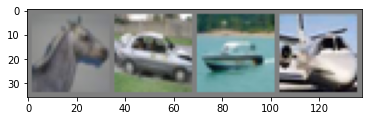

  Yes    No    No    No


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % pred_to_label[labels[j].item()] for j in range(batch_size)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
outputs

tensor([[ 0.0303, -0.0399],
        [ 0.0256, -0.0423],
        [ 0.0323, -0.0372],
        [ 0.0380, -0.0430]], grad_fn=<AddmmBackward>)

In [18]:
labels.int()

tensor([0, 0, 1, 0], dtype=torch.int32)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.499
[1,  4000] loss: 0.319
[1,  6000] loss: 0.291
[1,  8000] loss: 0.268
[1, 10000] loss: 0.274
[1, 12000] loss: 0.268
[2,  2000] loss: 0.244
[2,  4000] loss: 0.252
[2,  6000] loss: 0.242
[2,  8000] loss: 0.244
[2, 10000] loss: 0.243
[2, 12000] loss: 0.244
Finished Training


In [21]:
PATH = 'trained_model/cifar_animals_original.pth'
torch.save(net.state_dict(), PATH)

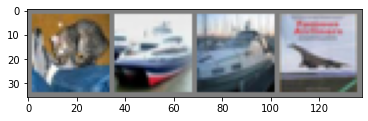

GroundTruth:    Yes    No    No    No


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % pred_to_label[labels[j].item()] for j in range(4)))

In [25]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
outputs = net(images)


In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % pred_to_label[predicted[j].item()]
                              for j in range(4)))

Predicted:    Yes    No    No    No


In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %
